In [89]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [90]:
mydata= pd.read_csv(".\\numismatics_0.csv")
old_size = mydata.size

In [91]:
# Keep only the datapoints where there are images available
mydata = mydata[mydata['image_url'].notnull()]
print("Removed:", old_size - mydata.size)

Removed: 144864


In [92]:
before_size = mydata.shape[0]
mydata = mydata.drop_duplicates()
after_size = mydata.shape[0]
print("Duplicates removed:", before_size - after_size)

Duplicates removed: 0


In [93]:
# Remove the 'g' in the weights comulmn
mydata['Weight'] =  mydata['Weight'].str.extract('(\d+)').astype(float)

### Playing around with cleaning / standardizing the Date data

First we want to see, how many unknowns, full knowns and partially unknowns do we have

We follow a step by step process
1) Everything fully unknown goes into one catagory -> ?
2) Any time there is a full date but they are not sure, choose that date
3) Choose the first available date 1625-1630 -> 1625
4) If the second number is missing 1??? we don't know enough so move to -> ?
5) Any time one or two numbers are missing: 162? or 17?? - Either remove or fill in 5 or 0 
6) Do a brief check if any date is < 1400 or > 1900 and set them to unknown (0)

#### After this we use linear regression to fill in the remaining missing dates.. about 1.000 or so
Don't do this for now, as we want to predict those 0 values

In [94]:
mydata[['Date']] = mydata[['Date']].fillna('?')
mydata['Date'] =   mydata['Date'].str.replace(r"\(|\)", "", regex=True)

In [95]:
# Example: Converting a column to a specific data type
#mydata['Date'] = pd.to_datetime(mydata['Date'], errors = 'coerce')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(mydata['Date'].value_counts())

Date
?                                        677
No Date                                  607
c.1650                                   452
No Date?1652                             415
No Date?1650                             402
c.1708                                   316
C. 1708                                  257
1620                                     255
c.1652                                   253
1622                                     240
1623                                     234
1653                                     213
1624                                     175
1621                                     174
1652                                     168
c. 1708                                  142
1619                                     114
no Date?1650                              99
c.1620                                    96
1654                                      88
1711                                      77
No Date?1651                              75
Not K

In [96]:
import regex as re
def count_consecutive_numbers(date):
    cntr = 0
    i = 0 # iterator
    date_list = [0,0,0]
    for c in date:
        i += 1
        if(c.isdigit()):
            cntr += 1
            if(cntr == 2):
                date_list[0] = int(date[i-cntr:i])
            if(cntr == 3):
                date_list[1] = int(date[i-cntr:i])
            if(cntr == 4):
                date_list[2] = int(date[i-cntr:i])
        else:
            cntr = 0
    
    number = np.argmax(date_list) # get the index of the max date
    return number + 2, date_list[number]

def replace_star_question(date):
    i = 0
    for c in date:
        if(c == '*' or c == '?'):
            if(i == 0):
                #print(date, ":", "1" + date[1:len(date)])
                return date.replace()
            elif(i == 2):
                return "15" + date[2:len(date)]
            elif(i == 3):
                return  date[0:1] + "5" + date[3:len(date)]
            elif(i == 4):
                return date[0:len(date)-1] + "0"
            i += 1


def replace_dates(date):
    if(not date.isalpha()):
        full_date = 0
        # We count the numbers in the string:
        numbers = sum(c.isdigit() for c in date)

        # If there are exactly 4 (or more) consecutive numbers we have a date
        # With more then 4 we just choose the first... simple
        consec_numbers = count_consecutive_numbers(date)
        if(numbers >= 4 and consec_numbers[0] == 4):
            full_date = int(consec_numbers[1])

        # if there are exactly 3 consecutive numbers we can swap the missing number for a 5
        elif(numbers == 3 and consec_numbers[0] == 3):
            # If the first number is missing replace with an one if it's the last with a 5
            if(consec_numbers[1] < 200):
                full_date = int(str(consec_numbers[1]) + "5")
            else:
                full_date = int("1" + str(consec_numbers[1]))

        # if there are exactly 2 consecutive numbers we can swap the missing number for a 50        
        elif(numbers == 2 and consec_numbers[0] == 2):
            # If the first and last are missing add 1 and 0 to the beginning and end respectively
            if(consec_numbers[1] > 20):
                full_date = int("1" + str(consec_numbers[1]) + "0")
            else:
                full_date = int(str(consec_numbers[1]) + "50")

        # There are cases where there's a ? or *. Depending on the position we can replace it
        # 0: 1, 2/3: 5, 4: 0
        else:
            new_string = date.replace('?', '1').replace('*', '1').replace(' ', '').replace('-','')
            numbers = sum(c.isdigit() for c in new_string)
            consec_numbers = count_consecutive_numbers(new_string)
            if(numbers >= 4 and consec_numbers[0] == 4):
                full_date = int(consec_numbers[1]) 

        if(full_date < 1400 and full_date > 0):
            full_date = 0
        elif(full_date > 1900):
            full_date = 0  
            
        return int(full_date)
        #if(full_date == 0):
        #    print(date + " :", numbers, " : ", consec_numbers[0], " : ", full_date)

In [97]:
# Use my new function to "clean" the dates
mydata['Date'] = mydata['Date'].apply(replace_dates)
#mydata['Date'] = mydata['Date'].replace(0, np.nan, inplace=True)

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

if(False):
    # Remove rows where 'Date' is NaN
    mydata = mydata.dropna(subset=['Date'])
    # Separate the dataset into two parts
    data_with_known_date = mydata[mydata['Date'] != 0]
    data_with_unknown_date = mydata[mydata['Date'] == 0]

    # One-Hot Encoding for the entire dataset (excluding rows where date is 0)
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(mydata[mydata['Date'] != 0].select_dtypes(include=['object']))

    # Encode the training set
    X_train_encoded = encoder.transform(data_with_known_date.select_dtypes(include=['object']))
    y_train = data_with_known_date['Date']

    # Train the model
    model = LinearRegression()
    model.fit(X_train_encoded, y_train)

    # Encode the prediction set
    X_unknown_encoded = encoder.transform(data_with_unknown_date.select_dtypes(include=['object']))

    # Predict the missing dates
    predicted_dates = model.predict(X_unknown_encoded)

    # Fill in the missing dates in the original dataset
    mydata.loc[mydata['Date'] == 0, 'Date'] = predicted_dates

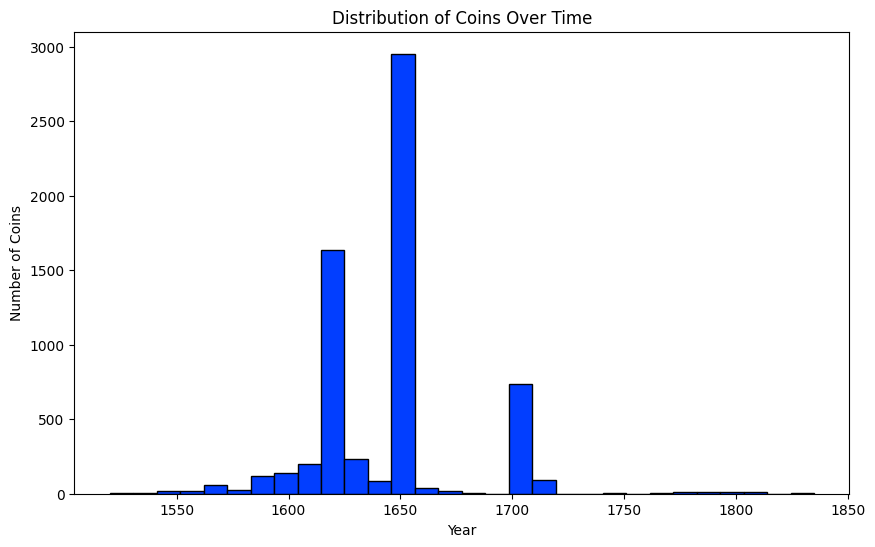

In [99]:
# Remove entries where 'Date' is 0
mydata_filtered = mydata[mydata['Date'] != 0]

# Plotting a histogram for 'Date'
plt.figure(figsize=(10, 6))
plt.hist(mydata_filtered['Date'], bins=30, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Coins')
plt.title('Distribution of Coins Over Time')
plt.show()

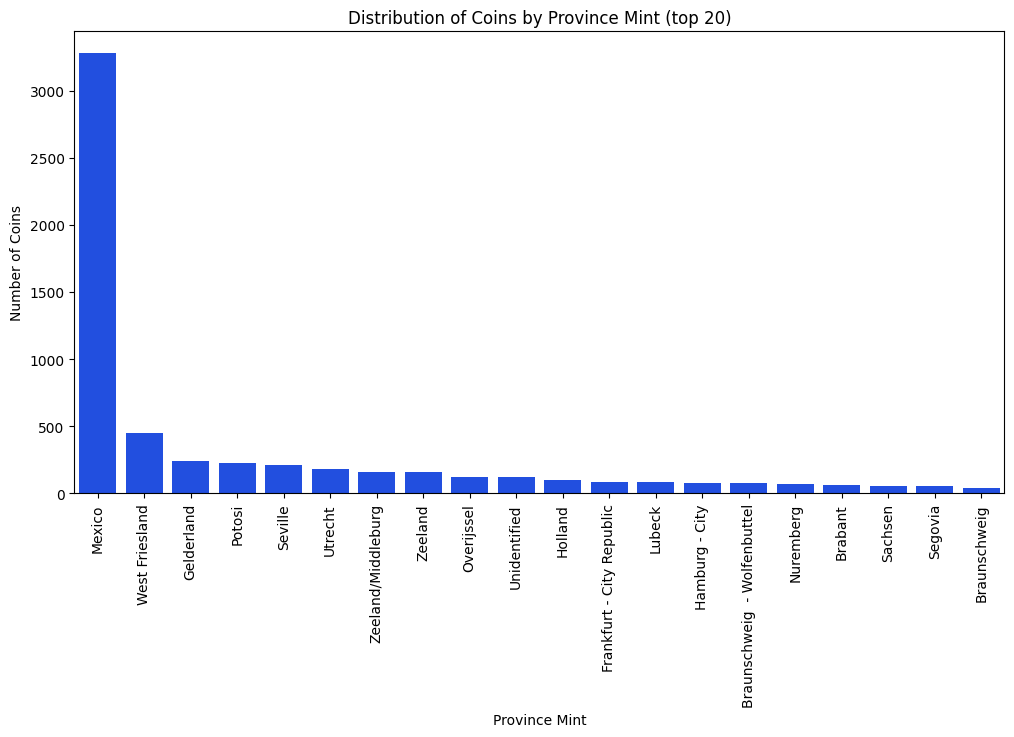

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each province mint
province_mint_counts = mydata_filtered['Province_Mint'].value_counts().head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=province_mint_counts.index, y=province_mint_counts.values)
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.xlabel('Province Mint')
plt.ylabel('Number of Coins')
plt.title('Distribution of Coins by Province Mint (top 20)')
plt.show()

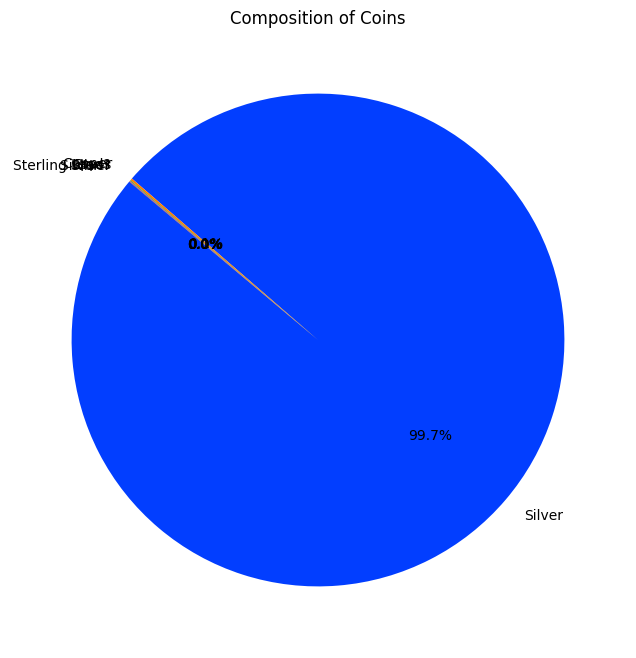

In [101]:
# Composition distribution
composition_counts = mydata['Composition'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(composition_counts, labels=composition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Composition of Coins')
plt.show()

In [102]:
# Assuming the 'Weight' column is already in a numeric format
# Calculate the IQR
Q1 = mydata['Weight'].quantile(0.25)
Q3 = mydata['Weight'].quantile(0.75)
IQR = Q3 - Q1

# Define thresholds for outliers
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Remove outliers
mydata = mydata[(mydata['Weight'] >= lower_threshold) & (mydata['Weight'] <= upper_threshold)]

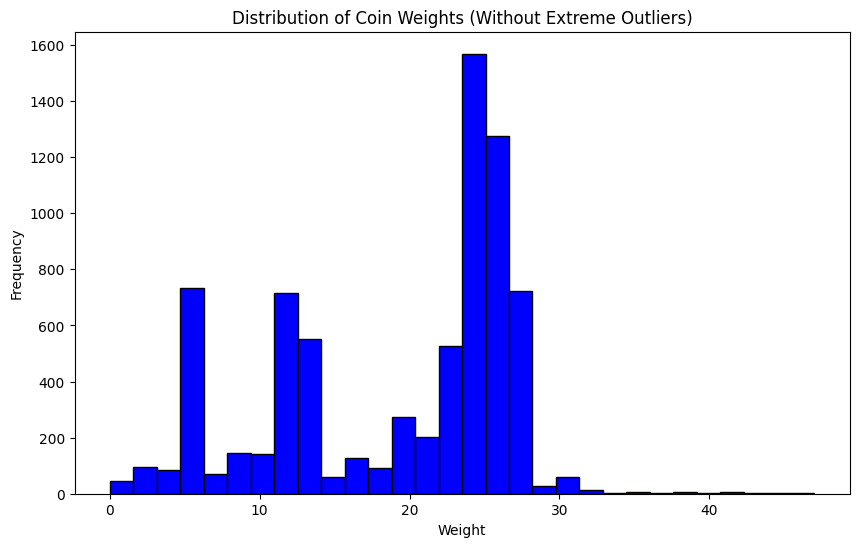

In [103]:
# Plot histogram with a reasonable number of bins
plt.figure(figsize=(10, 6))
plt.hist(mydata['Weight'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Coin Weights (Without Extreme Outliers)')
plt.show()

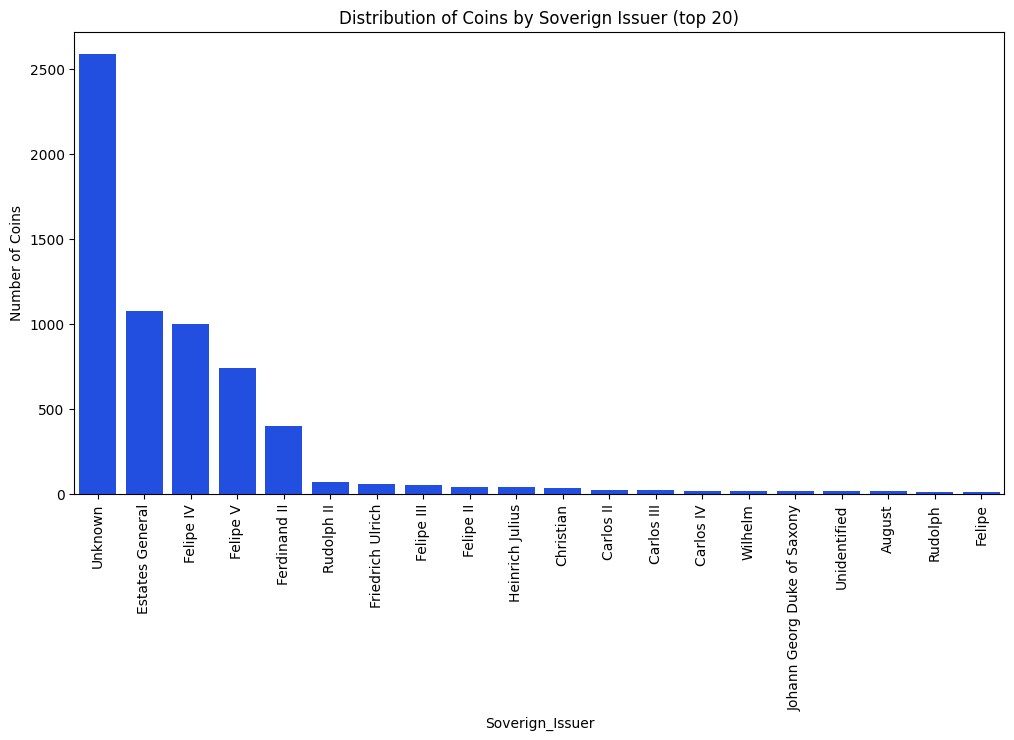

In [104]:
# Count the occurrences of each province mint
soverign_issuer_counts = mydata_filtered['Soverign_Issuer'].value_counts().head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=soverign_issuer_counts.index, y=soverign_issuer_counts.values)
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.xlabel('Soverign_Issuer')
plt.ylabel('Number of Coins')
plt.title('Distribution of Coins by Soverign Issuer (top 20)')
plt.show()

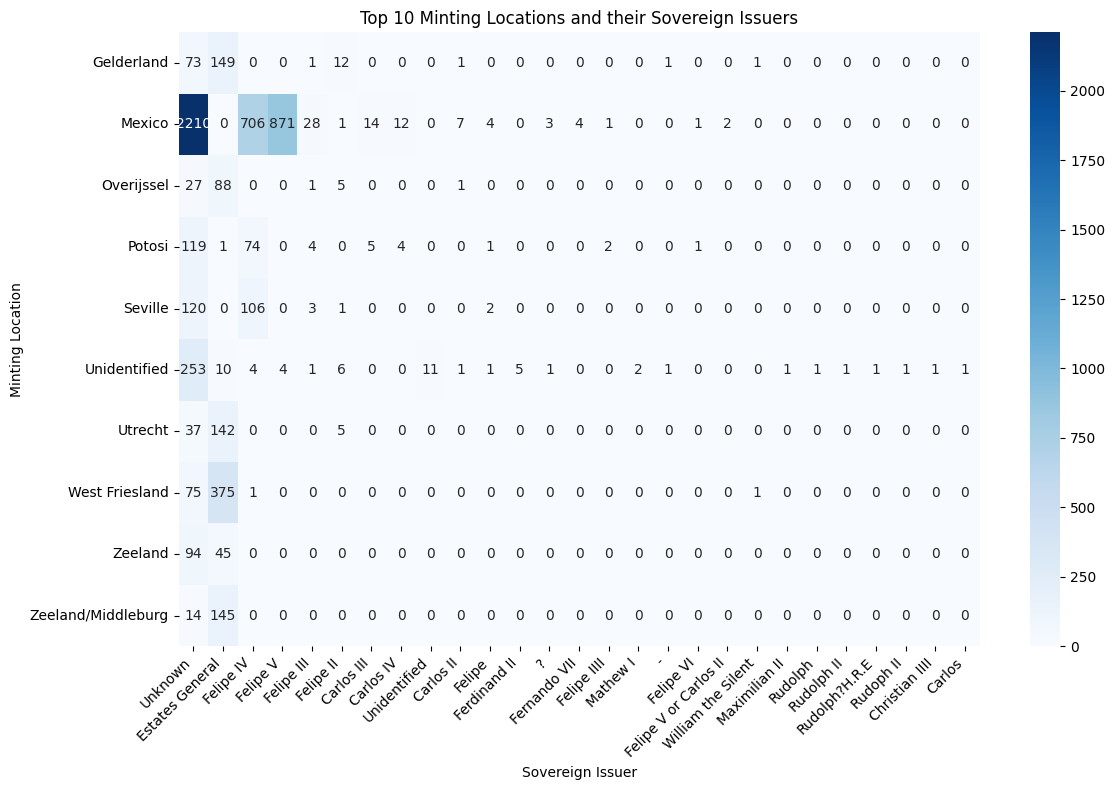

In [105]:
import seaborn as sns
# Find the top 10 minting locations based on frequency
top_mints = mydata['Province_Mint'].value_counts().head(10).index

# Filter the dataset to keep only the top 10 minting locations
mydata_top_mints = mydata[mydata['Province_Mint'].isin(top_mints)]

# Create a crosstab of the top 10 minting locations and their Sovereign Issuers
crosstab_data = pd.crosstab(mydata_top_mints['Province_Mint'], mydata_top_mints['Soverign_Issuer'])

# Sort the columns by the total counts to have the most frequent Sovereign Issuers appear first
crosstab_data = crosstab_data[crosstab_data.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_data, annot=True, fmt='d', cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Sovereign Issuer')
plt.ylabel('Minting Location')
plt.title('Top 10 Minting Locations and their Sovereign Issuers')
plt.tight_layout()  # Adjust layout to fit the plot and labels
plt.show()

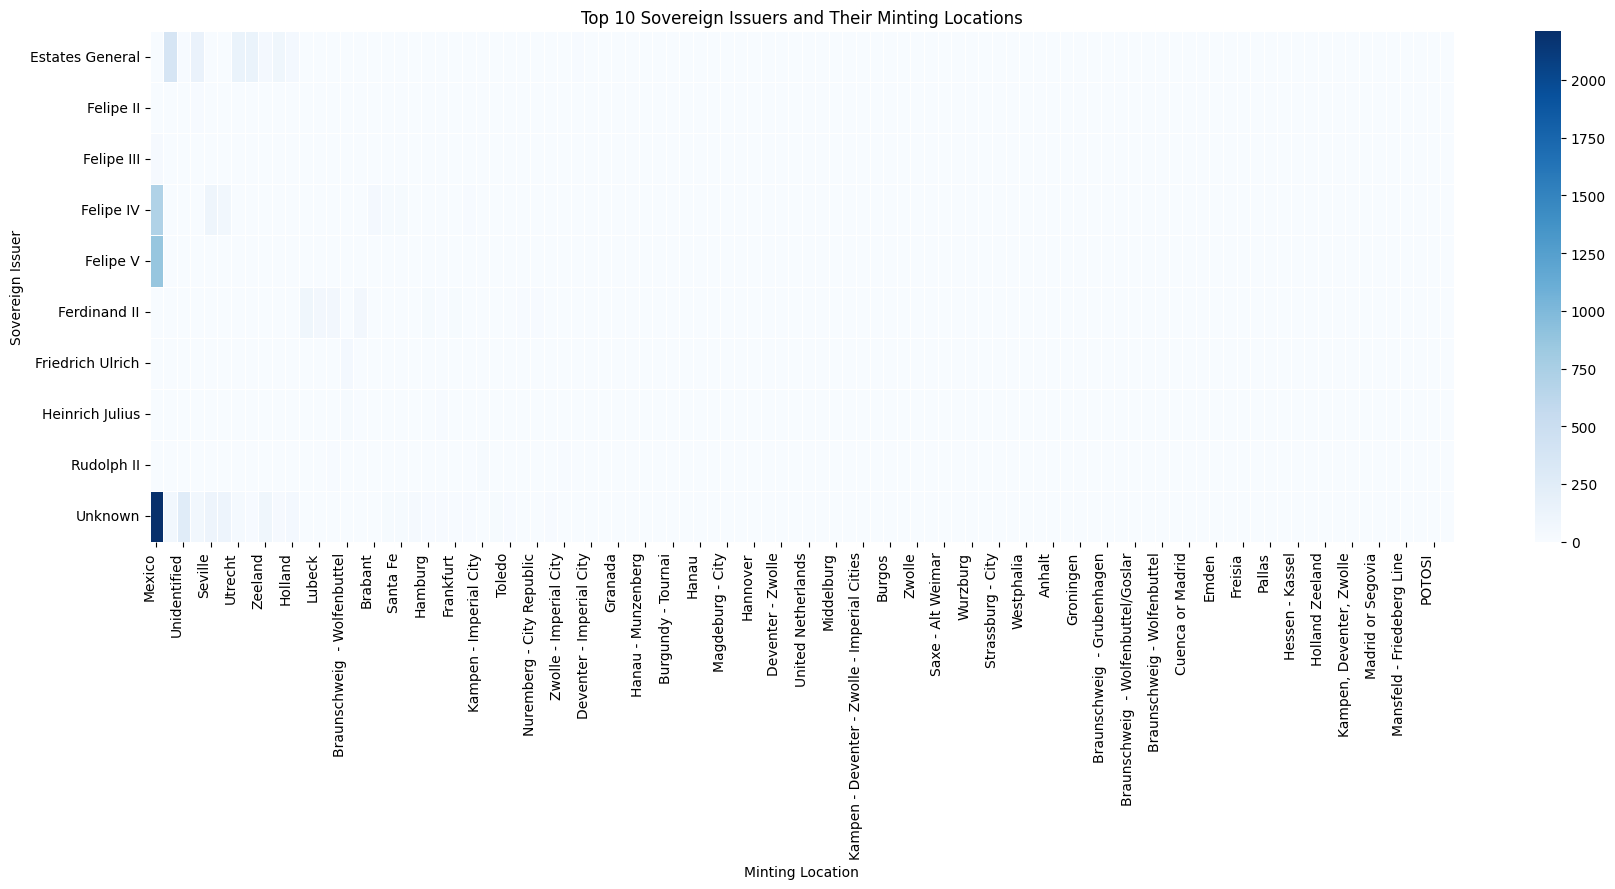

In [106]:
# Find the top 10 Sovereign Issuers based on frequency
top_sovereigns = mydata['Soverign_Issuer'].value_counts().head(10).index

# Filter the dataset to keep only the top 10 Sovereign Issuers
mydata_top_sovereigns = mydata[mydata['Soverign_Issuer'].isin(top_sovereigns)]

# Create a crosstab of the top 10 Sovereign Issuers and their minting locations
crosstab_data = pd.crosstab(mydata_top_sovereigns['Soverign_Issuer'], mydata_top_sovereigns['Province_Mint'].sort_values(ascending=False))

# Sort the columns by the total counts to have the most frequent minting locations appear first
crosstab_data = crosstab_data.loc[:, crosstab_data.sum(axis=0).sort_values(ascending=False).index]

# Increase the size of the heatmap
plt.figure(figsize=(18, 9))

# Create the heatmap without annotations
sns.heatmap(crosstab_data, cmap='Blues', linewidths=.5)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)

# Set the labels and title
plt.ylabel('Sovereign Issuer')
plt.xlabel('Minting Location')
plt.title('Top 10 Sovereign Issuers and Their Minting Locations')

# Use tight_layout to adjust subplot params
plt.tight_layout()

# Show the plot
plt.show()

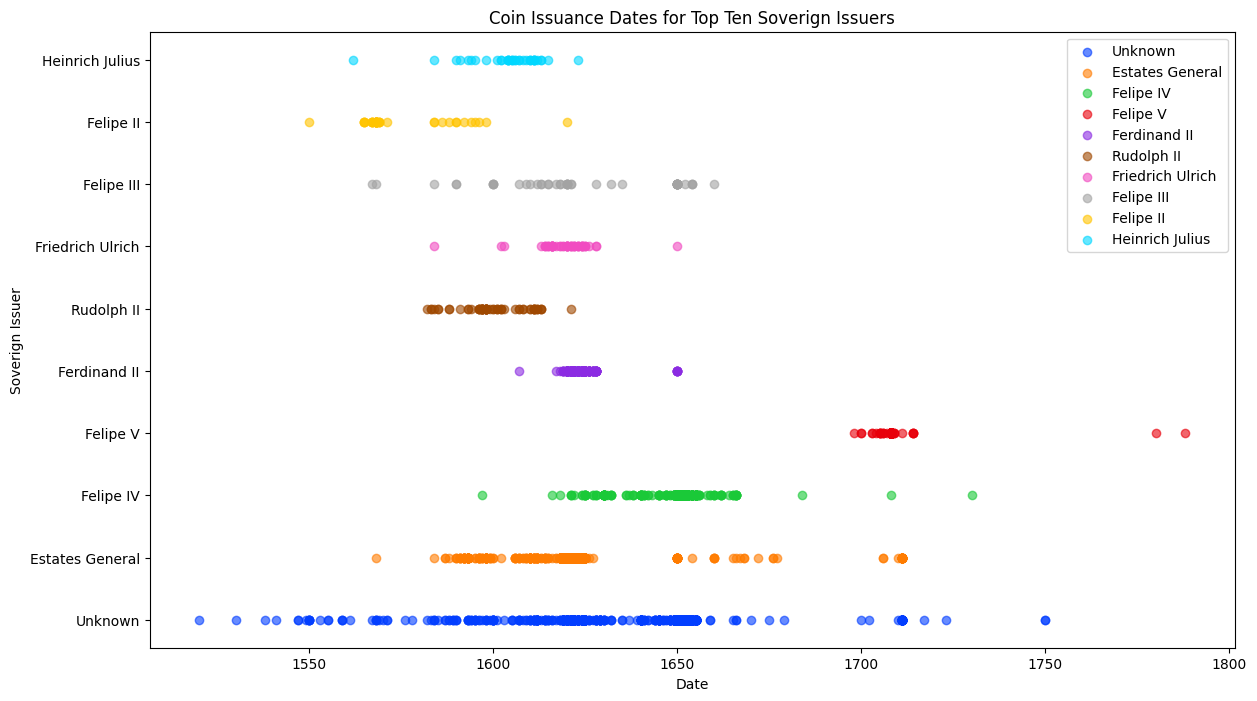

In [107]:
# Identify the top ten sovereign issuers
top_issuers = mydata_filtered['Soverign_Issuer'].value_counts().head(10).index

# Filter the dataset for only the top ten issuers
top_issuers_data = mydata_filtered[mydata_filtered['Soverign_Issuer'].isin(top_issuers)]

# Create a scatter plot
plt.figure(figsize=(14, 8))
for issuer in top_issuers:
    # Select data for this issuer
    issuer_data = top_issuers_data[top_issuers_data['Soverign_Issuer'] == issuer]
    plt.scatter(issuer_data['Date'], issuer_data['Soverign_Issuer'], label=issuer, alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Soverign Issuer')
plt.title('Coin Issuance Dates for Top Ten Soverign Issuers')
plt.legend()
plt.show()

In [108]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7556 entries, 1001 to 16012
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   7556 non-null   int64  
 1   Title                7556 non-null   object 
 2   Type                 7556 non-null   object 
 3   ANCODS               1085 non-null   object 
 4   Catalogue            3581 non-null   object 
 5   Composition          4096 non-null   object 
 6   Condition            4154 non-null   object 
 7   Date                 7524 non-null   float64
 8   thumb_url            7556 non-null   object 
 9   Mint_Mark            3337 non-null   object 
 10  Other_Details        3068 non-null   object 
 11  Province_Mint        7495 non-null   object 
 12  Registration_Number  4126 non-null   float64
 13  Soverign_Issuer      7361 non-null   object 
 14  Weight               7556 non-null   float64
 15  wreck                7203 non-null   ob

In [109]:
# There was just one variable for Type, so it's useless
mydata = mydata.drop('Type', axis=1)
# Drop ANCODS as it has no predictive value
mydata = mydata.drop('ANCODS', axis=1)
mydata = mydata.drop('thumb_url', axis=1)
mydata = mydata.drop('url', axis=1)
mydata = mydata.drop('ID', axis=1)
mydata = mydata.drop('Registration_Number', axis=1)


In [110]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(mydata['wreck'].value_counts())  

wreck
Vergulde Draak (Draeck) (Gilt Dragon)    3363
Batavia                                  2666
Zuiddorp (Zuytdorp)                      1111
Correio da Azia                            27
Rapid                                      20
Zeewijk                                    10
Belinda                                     5
Elizabeth                                   1
Name: count, dtype: int64


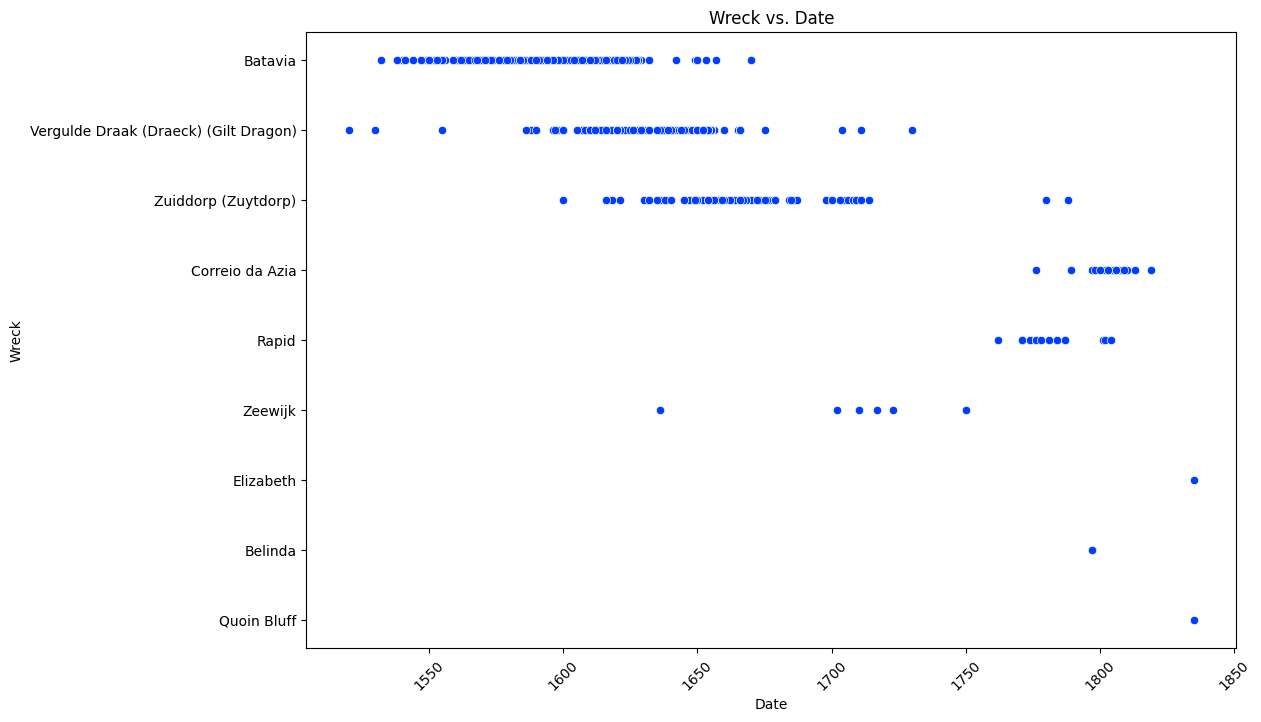

In [111]:
# Visualization: Wreck vs. Date
plt.figure(figsize=(12, 8))
sns.set_palette("bright")
sns.scatterplot(x='Date', y='wreck', data=mydata_filtered)
plt.xlabel('Date')
plt.ylabel('Wreck')
plt.title('Wreck vs. Date')
plt.xticks(rotation=45)
plt.show()

### Other feature engineering and cleaning / prepping
Thusfar I've worked on Date a lot and I've looked at various plots. One thing i've noticed is that it's probably wrong if a data point belonging to a certain wreck or rules is too far away from the others. It probably means it's date is wrong. I could work on this.

What else?

* Feature extracting from for example condition. There will probably a corralation between the images and the condition. Condition is in the form of object now, it could be catagories and perhaps we can limit the number
* same goes for some of the other variables

In [112]:
def extract_coin_type(title):
    # extract the substring in the title string from between - ... and ... (
    s = ""
    try:
        s = str.split(title, '-', 1)[1]
        s = str.split(s, '(', )[0].strip()
        #print(s)
        return s
    except:
        #print("ERROR: ", title)
        return "Unidentified" 

mydata['type'] = mydata['Title'].apply(extract_coin_type)

# Now that we're done with extracting the type data, drop Title:
mydata = mydata.drop('Title', axis=1)

c:\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python310\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python310\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = group

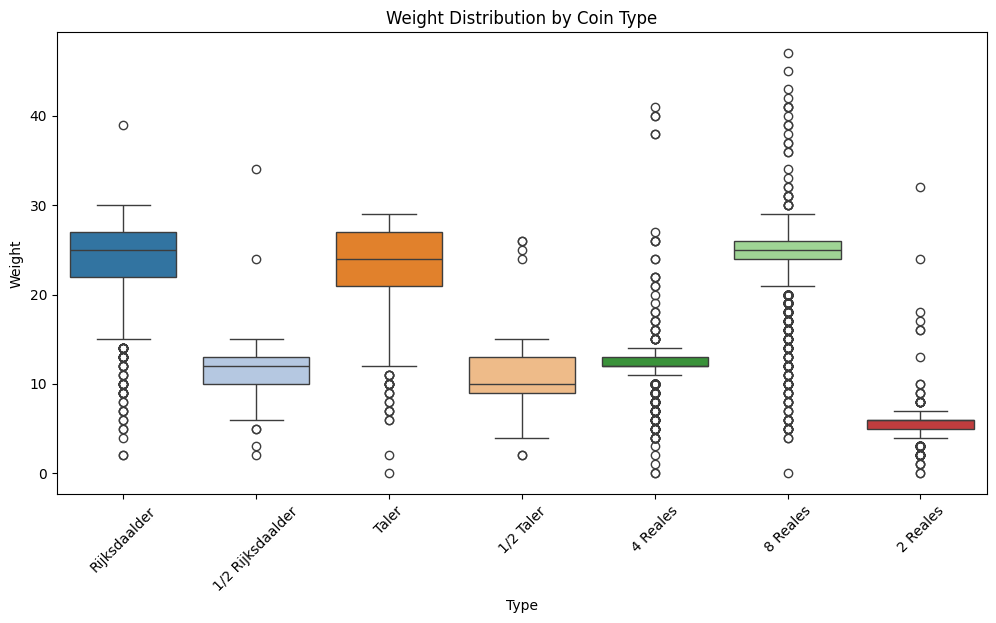

In [113]:
# Find the 7 most frequent types
top_seven_types = mydata['type'].value_counts().head(7).index

# Create a subset of the data with only these types
subset_mydata = mydata[mydata['type'].isin(top_seven_types)]

# Plot 'type' vs 'Weight'
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='Weight', data=subset_mydata, palette='tab20', hue='type')

plt.title('Weight Distribution by Coin Type')
plt.xlabel('Type')
plt.ylabel('Weight')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

In [114]:
mydata.nunique()

Catalogue           682
Composition           5
Condition           326
Date                175
Mint_Mark           495
Other_Details      1069
Province_Mint       150
Soverign_Issuer     144
Weight               47
wreck                 8
image_url          7556
type                 60
dtype: int64

In [115]:
# Optionally, save the updated dataset
updated_file_path = '.\\numismatic_updated.csv'
mydata.to_csv(updated_file_path, index=False)

### Make if(False) -> if(True) if you want to download all the images
Be carefull witht the next code; it will do a big download of the images

In [116]:
import requests
from PIL import Image
from io import BytesIO
import os
from concurrent.futures import ThreadPoolExecutor

# Directory to save images
images_dir = 'path_to_save_images'
os.makedirs(images_dir, exist_ok=True)

# Function to download an image
def download_image(data):
    url, filepath = data
    if not os.path.exists(filepath):  # Check if file already exists
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Check for HTTP errors

            # Assuming the response content is an image
            image = Image.open(BytesIO(response.content))
            image.save(filepath)
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error occurred: {http_err} - {url}")
        except Exception as e:
            print(f"Error occurred: {e} - {url}")

# List of tuples containing image URLs and filepaths
download_list = [
    (row['image_url'], os.path.join(images_dir, row['image_url'].split('/')[-1]))
    for index, row in mydata.iterrows()
]

# Download images concurrently
#with ThreadPoolExecutor(max_workers=20) as executor:
#    executor.map(download_image, download_list)

In [117]:
# Function to get local file path for an image
def get_local_image_path(image_url):
    image_filename = image_url.split('/')[-1]
    return os.path.join(images_dir, image_filename)

# Add a new column to the DataFrame with the local file paths
mydata['local_image_path'] = mydata['image_url'].apply(get_local_image_path)

# Drop image_url as it's served its purpose
mydata = mydata.drop('image_url', axis=1)

# Save the updated DataFrame to a new CSV file
updated_file_path = 'path_to_updated_csv_file.csv'  # Replace with your desired output file path
mydata.to_csv(updated_file_path, index=False)